In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import Counter
import random
import torch.nn.functional as F
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Carregar o modelo Word2Vec treinado
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, word_idx):
        embeds = self.embeddings(word_idx)
        return embeds

# Função para carregar o modelo com mapeamento para CPU
def load_model(model_path, vocab_size, embedding_dim):
    model = Word2Vec(vocab_size, embedding_dim)
    # Carregar o modelo mapeando para CPU
    #model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.load_state_dict(torch.load(model_path)) # -> Faz com a GPU
    return model


# Carregar o arquivo CSV contendo o vocabulário e as frequências
vocab_df = pd.read_csv("/teamspace/studios/this_studio/embedding/vocabulary.csv")

# Criar o dicionário mapeando palavras para índices
word_to_idx = {row['Word']: idx for idx, row in vocab_df.iterrows()}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)
embedding_dim = 1024

# Carregar o modelo
model = load_model("/teamspace/studios/this_studio/word2vec_model.pth", vocab_size, embedding_dim)
model.eval()


Word2Vec(
  (embeddings): Embedding(114036, 1024, sparse=True)
  (linear): Linear(in_features=1024, out_features=114036, bias=True)
)

In [3]:
# Função para obter a similaridade do cosseno entre dois embeddings
def cosine_similarity(vec1, vec2):
    # Achatar (flatten) os vetores se forem bidimensionais
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Função para obter o embedding de uma palavra
def get_embedding(word, model, word_to_idx):
    if word in word_to_idx:
        word_idx = torch.tensor([word_to_idx[word]], dtype=torch.long)
        embedding = model(word_idx).detach().numpy()
        return embedding
    else:
        return None

# Palavras sementes relacionadas à performance
seed_words = ['performance', 'speed', 'efficiency', 'optimization', 'latency']

# Obter os embeddings das palavras sementes
seed_embeddings = [get_embedding(word, model, word_to_idx) for word in seed_words]

# Criar uma lista para armazenar as similaridades
word_similarities = {}

# Iterar sobre todas as palavras no vocabulário e calcular a similaridade média com as sementes
for word in word_to_idx:
    word_emb = get_embedding(word, model, word_to_idx)
    if word_emb is not None:
        total_similarity = 0
        for seed_emb in seed_embeddings:
            total_similarity += cosine_similarity(word_emb, seed_emb)
        
        # Similaridade média com as palavras sementes
        word_similarities[word] = total_similarity / len(seed_embeddings)

# Ordenar as palavras pela similaridade (em ordem decrescente)
sorted_words = sorted(word_similarities.items(), key=lambda x: x[1], reverse=True)

# Mostrar as 20 palavras mais relacionadas à performance
print("Palavras mais relacionadas à performance:")
for word, score in sorted_words[:100]:
    print(f"{word}: {score}")


Palavras mais relacionadas à performance:
efficiency: 0.2162030514329672
speed: 0.20342858023941518
latency: 0.20176667468622328
optimization: 0.19877483360469342
performance: 0.1976924345828593
_newbt: 0.0652169268578291
paying: 0.060939083248376845
soundcoreisadmac: 0.060224272310733795
noterebbe: 0.059684430807828905
challenges: 0.05868757129646838
spfimc: 0.05854610949754715
virtuale: 0.05828426070511341
cmacroconfig_hibernation: 0.05795139092952013
baru: 0.05775025188922882
sys_dup: 0.057591886282898484
grass: 0.05698096975684166
testa: 0.056615366414189336
phy_initphy_exit: 0.05645247711800039
rb_parent: 0.0562737999483943
nobin: 0.05606987401843071
pr_alert: 0.05588393583893776
to_clk_foo_hw: 0.055577424354851246
awg: 0.05555216372013092
measured: 0.055400993674993515
netif_msg_link: 0.055174325779080394
ptp_general: 0.05515250377357006
fiddle: 0.0551494562998414
classfs: 0.05512483306229114
prerequisites: 0.05492483302950859
documentationmmremap_file_pagesrst: 0.054736323375254

In [4]:
# Função para obter o embedding de uma palavra
def get_embedding(word, model, word_to_idx):
    if word in word_to_idx:
        word_idx = torch.tensor([word_to_idx[word]], dtype=torch.long)
        embedding = model(word_idx).detach().numpy()
        return embedding
    else:
        return None

# Obter os embeddings de todas as palavras e achatar para garantir que sejam 2D
embeddings = np.array([get_embedding(word, model, word_to_idx).flatten() for word in word_to_idx], dtype=np.float64)  # Convertendo para float64
words = list(word_to_idx.keys())

# Reduzir a dimensionalidade para 100 componentes, por exemplo
pca = PCA(n_components=1024)
reduced_embeddings = pca.fit_transform(embeddings)

# Aplicar K-Means nos embeddings reduzidos
num_clusters = 10  # Escolha um número apropriado de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_embeddings)

# Encontrar o cluster que contém uma das palavras sementes, por exemplo, "performance"
seed_word = 'performance'
seed_word_embedding = get_embedding(seed_word, model, word_to_idx).flatten()
seed_word_embedding_reduced = pca.transform([seed_word_embedding])

# Converter para float64 para garantir compatibilidade
seed_word_embedding_reduced = seed_word_embedding_reduced.astype(np.float64)

seed_word_cluster = kmeans.predict(seed_word_embedding_reduced)

# Exibir palavras que estão no mesmo cluster que "performance"
related_words = [words[i] for i, label in enumerate(kmeans.labels_) if label == seed_word_cluster]

print(f"Palavras no cluster de '{seed_word}':")
print(related_words)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Palavras no cluster de 'performance':
['refdocumentationprocessintrorst', 'development_process_intro', 'git', 'linuxlinux', 'roland', 'matt', 'shibata', 'jochen', 'torvaldslinux', 'linuxgnu', 'sign', '_tw_development_process', 'rcrc', 'todotodo', 'stagingstaging', 'gitgit', 'mercurialgit', 'quiltmmquilt', 'development_early_stage', 'f', 'get_maintainerpl', 'system', 'support', 'three', 'installation', 'operation', 'operating', 'terminal', 'twenty', 'machine', 'commands', 'tn', 'way', 'talking', 'running', 'directory', 'rerun', 'changes', 'soon', 'tmpmkdev', 'type', 'cp', 'configure', 'immediately', 'oldconfig', 'edit', 'n', 'modules_install', 'respond', 'correctly', 'character', 'etcinittab', 'sbininit', 'first', 'actual', 'columns', 'connect', 'dialed', 'find', 'b', 'top', 'scrolling', 'sec', 'beginning', 'feeling', 'holding', 'newline', 'cause', 'job', 'pfz', 'end', 'characters', 'sends', 'otherwise', 'pfmkdir', 'want', 'etc', 'higher', 'caveats', 'without', 'february', 'mbs', 'simil

In [5]:
print(len(related_words))

15684


In [6]:
print("Palavras mais relacionadas à performance:")
for word in related_words[:20]:
    print(f"{word}")

Palavras mais relacionadas à performance:
refdocumentationprocessintrorst
development_process_intro
git
linuxlinux
roland
matt
shibata
jochen
torvaldslinux
linuxgnu
sign
_tw_development_process
rcrc
todotodo
stagingstaging
gitgit
mercurialgit
quiltmmquilt
development_early_stage
f


In [7]:
# Palavras sementes relacionadas à performance
seed_words = ['performance', 'speed', 'efficiency', 'optimization', 'latency']

# Obter embeddings das palavras sementes
seed_embeddings = [get_embedding(word, model, word_to_idx).flatten() for word in seed_words]

# Criar um dicionário para armazenar as similaridades
word_similarities = {}

# Calcular a similaridade de cada palavra no related_words com as palavras sementes
for word in related_words:
    word_emb = get_embedding(word, model, word_to_idx).flatten()
    
    total_similarity = 0
    for seed_emb in seed_embeddings:
        total_similarity += cosine_similarity(word_emb, seed_emb)
    
    # Similaridade média
    word_similarities[word] = total_similarity / len(seed_embeddings)

# Ordenar as palavras pela similaridade média com as sementes (em ordem decrescente)
sorted_related_words = sorted(word_similarities.items(), key=lambda x: x[1], reverse=True)

# Pegar as top 100 palavras mais relacionadas
top_related_words = [word for word, score in sorted_related_words[:100]]

# Exibir as top palavras mais relacionadas à performance
print("Top palavras relacionadas à performance:")
print(top_related_words)

Top palavras relacionadas à performance:
['performance', 'xmit_to_drv', 'rm_heap', 'uncompression', 'specdyn_pcm_assign', 'pairsqps', 'cpusysfsproccpuinfo', 'switch_mode', 'passthru_irq', 'bpf_map_update_elemlpm_fd', 'menus', 'arrayoption', 'jv', 'breakpoint', 'powern_cap_not_redundant', 'opened', 'commit_credsnew', 'mainstream', 'destroy_inodestruct', 'delayed_put_task_struct', 'frdcondsdepmz', 'httpdatasheetsmaximiccomendsmaxmaxpdf', 'drm_getmagic', 'vl_dv_bt_std_cvt', 'passthru', 'str_len', 'cpumasks_kfunc_map', 'dso', 'deepak', 'install_dtbs_path', 'toolstestingselftestsbpfxdp_hw_metadatac', 'fundamentalmente', 'digest_size', 'structunionenumkerneldoc', 'vmcb', 'javanmard', 'cfuncmei_cldev_register_notify_cb', 'handle_fd', 'loadmapregion', 'lblgov', 'cvegit', 'httpsclangllvmorg_', 'cfunciomap_zero_range', 'nongpl', 'scsi_scan_host', 'tscs', 'failed_suspend_noirq', 'pointlessly', 'sizeofaudio', 'noaperture', 'compilados', 'irqflagstracinglockdep', 'uv_register_mem_slot', 'parameters

In [8]:
# Carregar o dataset em formato parquet
dataset = pd.read_parquet("/teamspace/studios/this_studio/embedding/data.parquet")

# Obter os nomes das features (colunas do dataset)
feature_names = dataset.columns.tolist()

# Criar um dicionário para armazenar as similaridades das features
feature_similarities = {}

# Calcular a similaridade de cada feature com as palavras relacionadas à performance
for feature in feature_names:
    feature_emb = get_embedding(feature, model, word_to_idx)
    
    # Verificar se o embedding da feature foi encontrado
    if feature_emb is not None:
        feature_emb = feature_emb.flatten()
        total_similarity = 0
        for related_word in top_related_words:
            related_word_emb = get_embedding(related_word, model, word_to_idx).flatten()
            total_similarity += cosine_similarity(feature_emb, related_word_emb)
        
        # Similaridade média com todas as palavras relacionadas
        feature_similarities[feature] = total_similarity / len(top_related_words)

# Ordenar as features pela similaridade (em ordem decrescente)
sorted_features = sorted(feature_similarities.items(), key=lambda x: x[1], reverse=True)

# Selecionar as top 100 features mais relacionadas à performance
top_100_features = [feature for feature, score in sorted_features[:100]]

# Exibir as top 100 features
print("Top 100 features mais relacionadas à performance:")
print(top_100_features)
print(feature_similarities)


Top 100 features mais relacionadas à performance:
['perf']
{'perf': 0.0011473785969428718}


In [9]:
# Função para normalizar e dividir nomes compostos de features
def split_and_normalize_feature_name(feature):
    # Converter para minúsculas e dividir em palavras por underscores ou hífens
    parts = feature.lower().replace('_', ' ').replace('-', ' ').split()
    return parts

# Listas para armazenar features encontradas e não encontradas
features_in_word2vec = []
features_not_in_word2vec = []

# Verificar se cada feature ou suas partes estão no vocabulário do modelo Word2Vec
for feature in feature_names:
    normalized_parts = split_and_normalize_feature_name(feature)
    
    # Verificar se qualquer parte da feature está no vocabulário
    if any(part in word_to_idx for part in normalized_parts):
        features_in_word2vec.append(feature)
    else:
        features_not_in_word2vec.append(feature)

# Exibir o resultado
print(f"Total de features no dataset: {len(feature_names)}")
print(f"Total de features no modelo Word2Vec (após divisão): {len(features_in_word2vec)}")
print(f"Total de features não encontradas no modelo Word2Vec (após divisão): {len(features_not_in_word2vec)}")

# Exibir as features que não estão no modelo Word2Vec
if features_not_in_word2vec:
    print("\nFeatures não encontradas no modelo Word2Vec (após divisão):")
    print(features_not_in_word2vec)
else:
    print("\nTodas as features do dataset estão no modelo Word2Vec.")


Total de features no dataset: 9469
Total de features no modelo Word2Vec (após divisão): 8643
Total de features não encontradas no modelo Word2Vec (após divisão): 826

Features não encontradas no modelo Word2Vec (após divisão):
['VSOCKETS', 'ATH9K_DYNACK', 'ATH9K_PCOEM', 'X86_X32', 'X86_P4_CLOCKMOD', 'CARL9170', 'X86_LONGRUN', 'X86_LONGHAUL', 'ATH6KL', 'ADIS16203', 'ADIS16209', 'HIGHMEM4G', 'ADIS16240', 'NOHIGHMEM', 'AD7606', 'HIGHMEM64G', 'VMSPLIT_3G', 'SYSC_R8A7743', 'SYSC_R8A7745', 'VMSPLIT_2G', 'AD7780', 'SYSC_R8A7779', 'SYSC_R8A7790', 'AD7816', 'SYSC_R8A7791', 'AD7192', 'SYSC_R8A7792', 'AD7280', 'SYSC_R8A7794', 'ADT7316', 'SYSC_R8A7795', 'SYSC_R8A7796', 'ADT7316_I2C', 'B44', 'QEDE', 'HISAX_NO_SENDCOMPLETE', 'HISAX_1TR6', 'QCA7000', 'HISAX_NI1', 'HISAX_16_3', 'HISAX_TELESPCI', 'ATP', '8139CP', 'HISAX_S0BOX', 'HISAX_AVM_A1', '8139TOO', 'HISAX_FRITZPCI', '8139TOO_8129', 'BH1780', 'CM32181', 'CM3232', 'CM3323', 'CM3605', 'CM36651', 'GP2AP020A00F', 'ISL29125', 'JSA1212', 'RPR0521', 'QRT

In [10]:
# Calcular a similaridade de cada feature (pelo nome original) com as palavras relacionadas à performance
for feature in feature_names:
    normalized_parts = split_and_normalize_feature_name(feature)
    
    # Verificar se qualquer parte da feature está no vocabulário
    found_parts = [part for part in normalized_parts if part in word_to_idx]
    
    if found_parts:
        # Obter o embedding da primeira parte encontrada no vocabulário
        feature_emb = get_embedding(found_parts[0], model, word_to_idx).flatten()
        
        total_similarity = 0
        for related_word in top_related_words:
            related_word_emb = get_embedding(related_word, model, word_to_idx).flatten()
            total_similarity += cosine_similarity(feature_emb, related_word_emb)
        
        # Similaridade média com todas as palavras relacionadas
        feature_similarities[feature] = total_similarity / len(top_related_words)

# Ordenar as features pela similaridade (em ordem decrescente)
sorted_features = sorted(feature_similarities.items(), key=lambda x: x[1], reverse=True)

# Selecionar as top 100 features mais relacionadas à performance
top_100_features = [feature for feature, score in sorted_features[:100]]

# Exibir as top 100 features com o nome original
print("Top 100 features mais relacionadas à performance:")
for features in top_100_features[:20]:
    print(f"{features}")

Top 100 features mais relacionadas à performance:
OF_ALL_DTBS
X86_EXTENDED_PLATFORM
MODULES
MODULES_USE_ELF_RELA
MODULES_USE_ELF_REL
VF610_ADC
AT91_SAMA5D2_ADC
AXP288_ADC
CC10001_ADC
CPCAP_ADC
MXS_LRADC_ADC
INA2XX_ADC
IMX7D_ADC
LPC18XX_ADC
LPC32XX_ADC
STM32_ADC_CORE
STM32_ADC
VIPERBOARD_ADC
PCF50633_ADC
AXP20X_ADC


In [11]:
# Criar um DataFrame com as top 100 features e seus scores
df_top_100_features = pd.DataFrame(sorted_features[:100], columns=["Feature", "Similarity"])

# Salvar o DataFrame em um arquivo CSV
df_top_100_features.to_csv("top_100_features_performance.csv", index=False)

# Exibir as primeiras linhas para visualização
df_top_100_features.head()

,Feature,Similarity
0,OF_ALL_DTBS,0.015860
1,X86_EXTENDED_PLATFORM,0.015090
2,MODULES,0.013622
3,MODULES_USE_ELF_RELA,0.013622
4,MODULES_USE_ELF_REL,0.013622


### Visualização

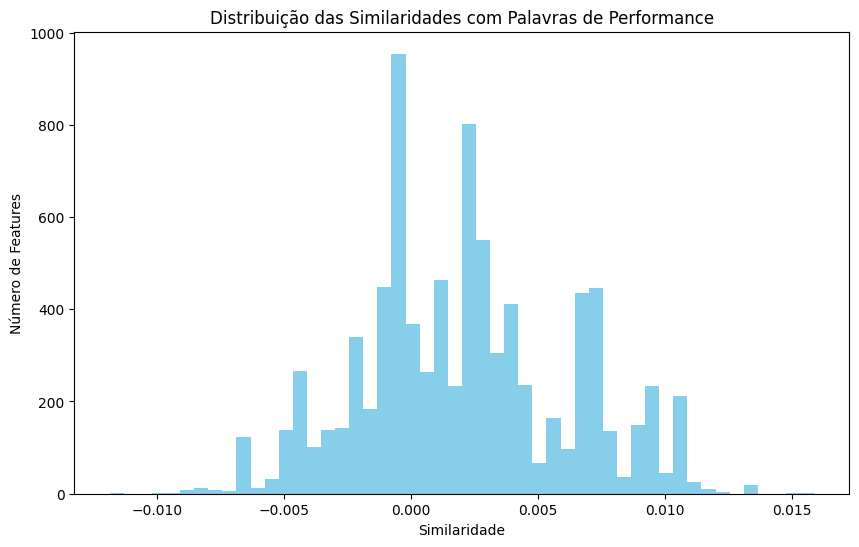

In [15]:
# Gráfico de Distribuição das Similaridades
similarities = list(feature_similarities.values())
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=50, color='skyblue')
plt.title('Distribuição das Similaridades com Palavras de Performance')
plt.xlabel('Similaridade')
plt.ylabel('Número de Features')
plt.show()


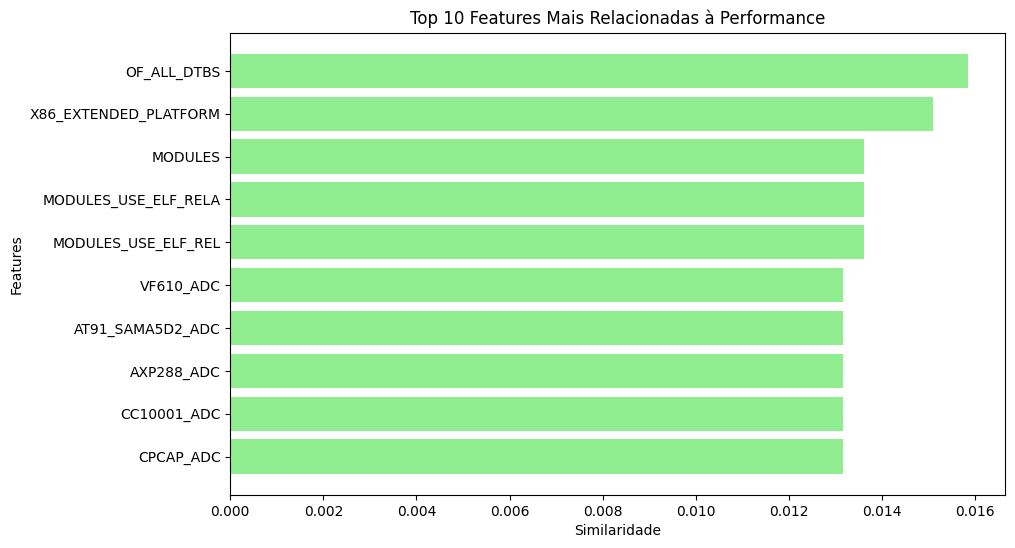

In [16]:
# Gráfico de Barras das Top 10 Features
top_10_features = sorted_features[:10]
features, similarities = zip(*top_10_features)
plt.figure(figsize=(10, 6))
plt.barh(features, similarities, color='lightgreen')
plt.title('Top 10 Features Mais Relacionadas à Performance')
plt.xlabel('Similaridade')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()


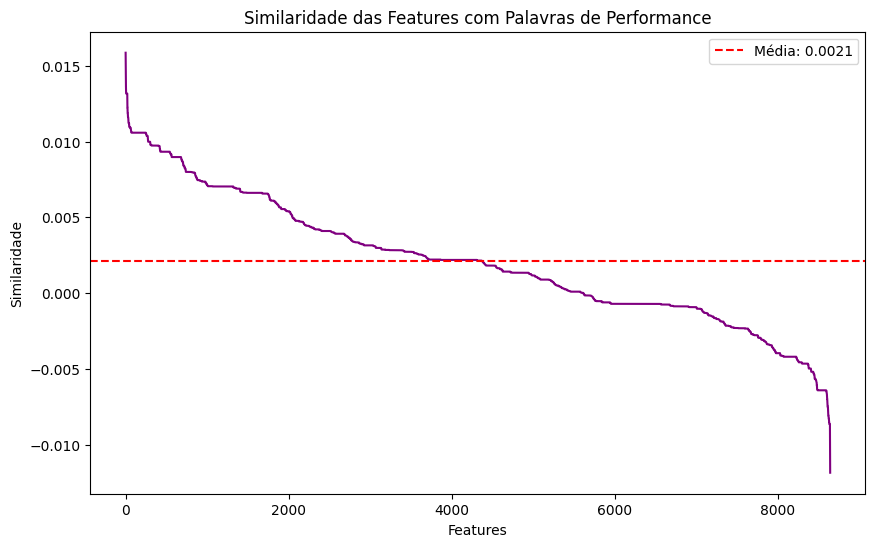

In [17]:
# Gráfico de Similaridade Média
similarities = [score for _, score in sorted_features]
mean_similarity = np.mean(similarities)

plt.figure(figsize=(10, 6))
plt.plot(similarities, color='purple')
plt.axhline(y=mean_similarity, color='r', linestyle='--', label=f'Média: {mean_similarity:.4f}')
plt.title('Similaridade das Features com Palavras de Performance')
plt.xlabel('Features')
plt.ylabel('Similaridade')
plt.legend()
plt.show()

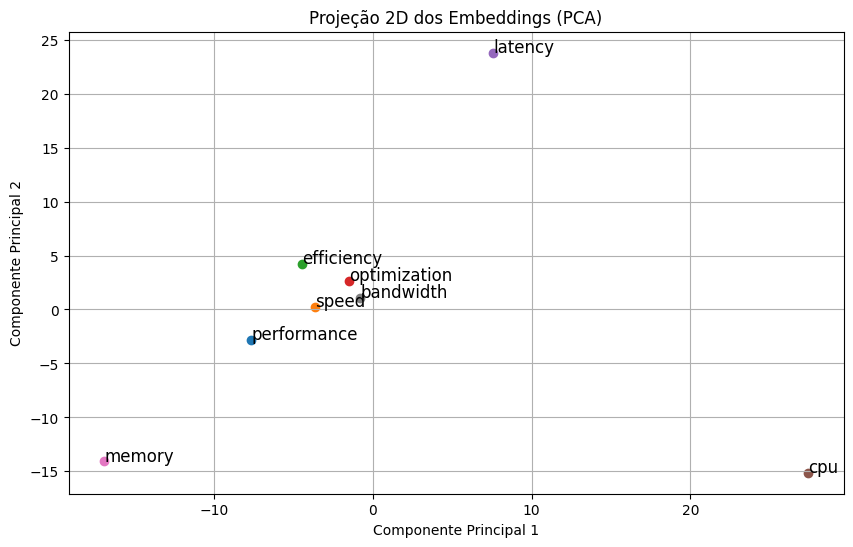

In [23]:
# Projeção 2D dos Embeddings do Word2Vec (PCA)
word_list = ['performance', 'speed', 'efficiency', 'optimization', 'latency', 'cpu', 'memory', 'bandwidth']
# Obter os embeddings das palavras
embeddings = np.array([get_embedding(word, model, word_to_idx).flatten() for word in word_list])
# Reduzir para 2D com PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
plt.figure(figsize=(10, 6))
for i, word in enumerate(word_list):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
    plt.text(reduced_embeddings[i, 0] + 0.02, reduced_embeddings[i, 1] + 0.02, word, fontsize=12)

plt.title('Projeção 2D dos Embeddings (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()